In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from scipy.optimize import *
from skimage.transform import rescale

In [33]:
from numpy import pi
from scipy import special
import time

In [34]:
t_st = time.time()
for i in range(1000):
    y = np.linspace(-pi,pi,10000)
    dy = 2*pi/10000
    k = 1
    mu = pi/4
    lam = 2
    z = 2*pi*np.exp(k*np.cos(y-mu))*special.iv(0,lam*np.sin(y))
    #plt.plot(y,z,'r')
    sum(z)*dy
t_en = time.time()
print((t_en - t_st)*1000/3600)

0.935422248310513


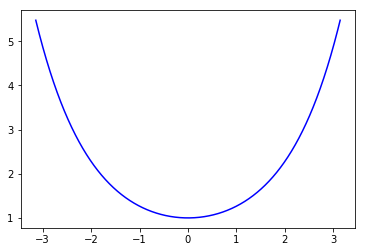

In [35]:
p = special.iv(0,y)
plt.plot(y,p,'b')

In [3]:
# First define the joint distribution
# Using a grid structure of the random variables
Nx = 6
Ny = 8
N = Nx*Ny # no. of variables
K = 0.5*np.ones([N]) # concentration parameters
# assuming zero mean for now

# Generate indices for the nodes in this graph
IndexMat = np.reshape(np.cumsum(np.ones([N],dtype=int)),[Nx,Ny])-1

SMat = np.zeros([N,N]) # adjacency matrix

# # Now populate the adjacency matrix based on the grid connectivity: 
# # up-down and left-right neigbors only.
# # Also include extra checks for the nodes at the edges of the grid.

for ii in range(Nx):
    for jj in range(Ny):
        # first look for the left and right entries
        if jj == 0:
            SMat[IndexMat[ii,jj],IndexMat[ii,jj+1]] = 1
        elif jj == Ny-1:     
            SMat[IndexMat[ii,jj],IndexMat[ii,jj-1]] = 1;
        else:
            SMat[IndexMat[ii,jj],IndexMat[ii,jj+1]] = 1;
            SMat[IndexMat[ii,jj],IndexMat[ii,jj-1]] = 1;
        
        # Next look for the up and down entries
        if ii == 0:
            SMat[IndexMat[ii+1,jj],IndexMat[ii,jj]] = 1;
        elif ii == Nx-1:
            SMat[IndexMat[ii-1,jj],IndexMat[ii,jj]] = 1;
        else:
            SMat[IndexMat[ii+1,jj],IndexMat[ii,jj]] = 1;
            SMat[IndexMat[ii-1,jj],IndexMat[ii,jj]] = 1;
            
            
LMat = 1*SMat # for now, all the interactions have the same value


# # another type of interaction matrix .. based on distance of the pixels from each other
# LMat = np.zeros([N,N])
# d0 = 1/2
# for ii in range(N):
#     xi,yi = np.nonzero(IndexMat == ii)
#     for jj in range(ii):
#         xj,yj = np.nonzero(IndexMat == jj)
#         d = np.sqrt((xi-xj)**2 + (yi-yj)**2)
#         #dd = np.abs(xi-xj) + np.abs(yi-yj)
#         LMat[ii,jj] = np.exp(-d/d0)/np.exp(-1/d0)
        
# LMat = LMat + LMat.T

In [4]:
IndexMat

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47]])

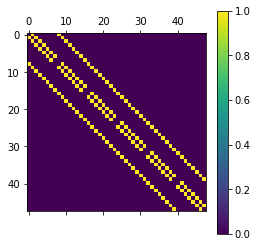

In [5]:
plt.matshow(LMat)
plt.colorbar()

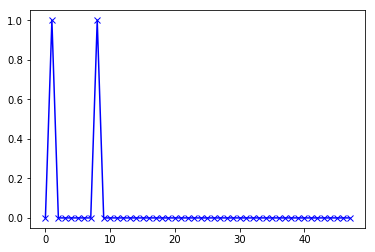

In [337]:
plt.plot(LMat[0,:],'bx-')

In [6]:
# Gibbs sampling to obtain samples from the multivariate von mises distribution
# write the for loop for the Gibbs sampling
Nsamples = 5

thetamat = np.zeros([N,Nsamples])

thetaVec = np.zeros([N])
# initialize the values of the angles
for ii in range(N):
    thetaVec[ii] = np.random.vonmises(0,K[ii],[1])
    
# initial burn in period
for k in range(1000):
    for j in range(N):
        kj = K[j]
        Lj = np.dot(LMat[j,:],np.sin(thetaVec))
        aj = np.sqrt(kj**2 + Lj**2)
        phij = np.arctan(Lj/kj)
        thetaVec[j] = np.random.vonmises(phij, aj, [1])
        

for kk in range(Nsamples):
    for k in range(100):
        for j in range(N):
            kj = K[j]
            Lj = np.dot(LMat[j,:],np.sin(thetaVec))
            aj = np.sqrt(kj**2 + Lj**2)
            phij = np.arctan(Lj/kj)
            thetaVec[j] = np.random.vonmises(phij, aj, [1])
            
    thetamat[:,kk] = thetaVec
    
    

In [360]:
covmat = np.cov(thetamat)

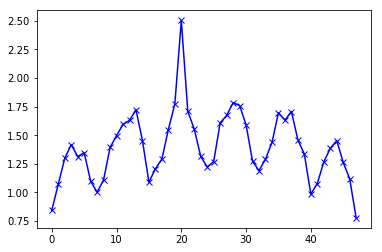

In [363]:
plt.plot(covmat[20,:],'bx-')

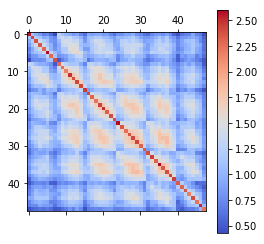

In [362]:
# plt.matshow(covmat,vmin = 0, vmax = np.max(covmat),cmap='coolwarm')
plt.matshow(covmat,vmin = np.min(covmat), vmax = np.max(covmat),cmap='coolwarm')
plt.colorbar()

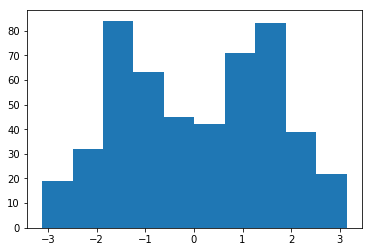

In [364]:
plt.hist(thetamat[2,:],10)
plt.show()

191


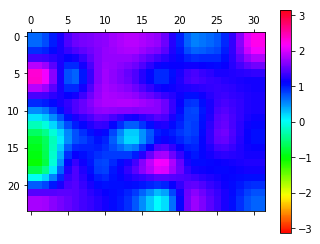

In [369]:
idx = np.random.randint(Nsamples)
print(idx)
temp = np.reshape(thetamat[:,idx],[Nx,Ny])
temp = rescale(temp,4,mode='edge')
plt.matshow(temp,vmin = -np.pi, vmax = np.pi,cmap='hsv')
plt.colorbar()


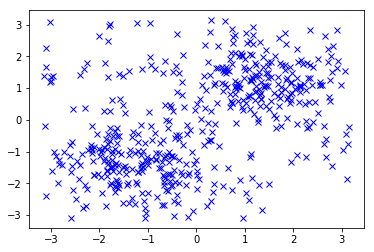

In [370]:
plt.plot(thetamat[0,:],thetamat[1,:],'bx')

In [349]:
from mpl_toolkits.mplot3d import Axes3D

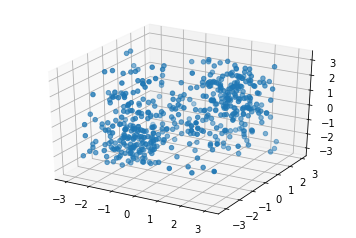

In [354]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(thetamat[1,:],thetamat[2,:],thetamat[40,:])
